# Analysing Log data

In [1]:
import pandas as pd
import numpy as np
import urllib
from datetime import date
import urllib.parse
from datetime import datetime as dt
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as ticker

In [2]:
# Get the collection name from the user
collection_input = input("Enter the collection name (leave blank for all):: ")
organisation_input = input("Enter the organisation (leave blank for all): ")
endpoint_input = input("Enter the endpoint (leave blank for all): ")
date_input = input("Enter the date(yyyy-mm-dd format) (leave blank for current date): ")

Enter the collection name (leave blank for all):: brownfield-land
Enter the organisation (leave blank for all): 
Enter the endpoint (leave blank for all): 
Enter the date(yyyy-mm-dd format) (leave blank for current date): 2023-07-13


# Detailed List of endpoints processed on provided date

In [3]:
datasette_url = "https://datasette.planning.data.gov.uk/"

# Get the current date
# current_date = dt.now().date()
# previous_date = current_date - datetime.timedelta(days=1)

current_date = dt.now().date()
if date_input:
    current_date = date_input
    

# Build the query to filter records for today's date
date_query = f" where substr(l.entry_date, 1, 10) = '{current_date}'"

query = ""
if collection_input:
    query = f" and s.collection = '{collection_input}'"
    
if organisation_input:
    query = f" and s.organisation = '{organisation_input}'"
    
if endpoint_input:
    query = f" and l.endpoint = '{endpoint_input}'"

params = urllib.parse.urlencode({
    "sql": f"""
    select l.endpoint,l.resource,s.collection, s.organisation,
    l.entry_date, l.end_date,l.start_date,l.status, l.exception
    from log l
    inner join source s
    on l.endpoint = s.endpoint
    {date_query}
    {query}
    order by l.entry_date desc
    """,
    "_size": "max"
})



url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url)
print("\033[1m List of endpoints processed on: ",current_date)
df


 List of endpoints processed since yesterday


,endpoint,resource,collection,organisation,entry_date,end_date,start_date,status,exception
0,e17137a06b3071845cd87dc093827b5212db1a0f782079...,cb0af9b4b276cdc6c150ce187006009e235e057d83ad3f...,brownfield-land,local-authority-eng:HAL,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN
1,466796e9f6e18591dead03d9e7836e02d6494ec1a5ac9e...,NaN,brownfield-land,local-authority-eng:WYO,2023-07-13T00:22:11Z,NaN,NaN,NaN,SSLError
2,512cfbf557558203d0012e1d95388bb01d30edd9b61672...,NaN,brownfield-land,local-authority-eng:BPL,2023-07-13T00:22:11Z,NaN,NaN,404.0,NaN
3,8192467350b3e9a7f223a6cea958ba0f7434231151d704...,NaN,brownfield-land,local-authority-eng:RED,2023-07-13T00:22:11Z,NaN,NaN,404.0,NaN
4,cf91b1e94fe298ecf6383060c79b3dd7d030cdfd00bda9...,49a918dc51d8d4063061e5b0d257943aa194370ae1f07a...,brownfield-land,local-authority-eng:BAB,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...
818,2236b9b65ee4dc2fb6528ae3863a3aa31eb2230c1a13ab...,c9763c5460ed99a2f82c49eafccf66053593f0b7c505cb...,brownfield-land,local-authority-eng:ERY,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN
819,c55843639d58ae8ddc8dac953e89e9525815270440b0ed...,6de52a900ceb17b5e9bc0b51cd6c4b472c229f56cb3ae1...,brownfield-land,local-authority-eng:ESK,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN
820,8a8bc4eb95452d11da4d2b9b736ac1cb3a9166610e868b...,2a71a7cd0f063bf460c500f7ec4aeb31c960a9d797ec68...,brownfield-land,local-authority-eng:EST,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN
821,474cf5e496eec47aab8d950b669d9d4f2358a0b618744b...,dda69588484b738fc11766920157bf7dbed8bad220109d...,brownfield-land,local-authority-eng:EXE,2023-07-13T00:22:11Z,NaN,NaN,200.0,NaN


In [4]:
download = input("Do you want to download the result? (yes/no): ")

if download.lower() == "yes":
    # Save the DataFrame as a CSV file
    df.to_csv("query_result.csv", index=False)
    print("Query result downloaded as 'query_result.csv'")

Do you want to download the result? (yes/no): no


# Count of endpoints erroring/succesful

In [5]:
# Construct the params for the Datasette API request
params = urllib.parse.urlencode({
    "sql": f"""
    select substr(l.entry_date, 1, 10) as date, s.collection, l.status, count(*) as 'count(endpoint)' from log l
    inner join source s
    on l.endpoint = s.endpoint
    {date_query}
    group by l.entry_date, l.status
    order by l.entry_date desc
    """,
    "_size": "max"
})

# Construct the URL for the Datasette API request
url = f"{datasette_url}digital-land.csv?{params}"

# Read the CSV data from the URL into a DataFrame
df = pd.read_csv(url, dtype={'status': str})

# Create a new column "result" to represent "OK" or "Error" based on the status
df["result"] = df["status"].apply(lambda status: "OK" if status == "200" else "Error")

# Pivot the DataFrame to reshape the data
df_pivot = df.pivot_table(index=["collection"], columns=["status", "result"], values="count(endpoint)", fill_value=0)

# Search for the columns with "OK" and "Error" values
ok_columns = [col for col in df_pivot.columns if col[1] == "OK"]
error_columns = [col for col in df_pivot.columns if col[1] == "Error"]

# Calculate the "error_total" column if "Error" columns exist in the pivot table
if error_columns:
    df_pivot["error_total"] = df_pivot[error_columns].sum(axis=1)
else:
    df_pivot["error_total"] = 0

error_code_columns = [col for col in df_pivot.columns if col[1].startswith("Error")]
df_pivot[error_code_columns] = df_pivot[error_code_columns].astype(int)

# Calculate the sum of "OK" rows and "error_total" rows
ok_total = df_pivot[ok_columns].sum().sum()
error_total = df_pivot["error_total"].sum()

# Create a new DataFrame row for the total
total_row = pd.DataFrame([[ok_total] + list(df_pivot[error_code_columns].sum()) + [error_total]], 
                         columns=pd.MultiIndex.from_tuples([("200", "OK")] + error_code_columns + [("error_total", "")]), 
                         index=["Total"])

# Concatenate the total row to the DataFrame
df_pivot = pd.concat([df_pivot, total_row])

# Highlight function to apply background color
def highlight_total(s):
    # Create an empty style
    style = pd.DataFrame('', index=s.index, columns=s.columns)
    # Set background color for ok_total column to light green
    style.loc[:, pd.IndexSlice[:, "OK"]] = 'background-color: lightgreen'
    style.loc["Total", pd.IndexSlice[:, "OK"]] = 'background-color: lightgreen;font-weight: bold;font-size: 16px;'
    # Set background color for error_total to light red
    
    style.loc[:, ("error_total", "")] = 'background-color: lightcoral'
    style.loc["Total", ("error_total", "")] = 'background-color: lightcoral;font-weight: bold;font-size: 16px;'
     
    return style

# Apply the highlight function to the DataFrame
styled_df_pivot = df_pivot.style.apply(highlight_total, axis=None)

print("\033[1m Count of endpoints erroring/successful on ", current_date)
# Display the styled DataFrame
styled_df_pivot


 Count of endpoints erroring/successful on  2023-07-13


,200,400,403,404,410,429,500,502,503,error_total
,OK,Error,Error,Error,Error,Error,Error,Error,Error,
ancient-woodland,2,0,0,0,0,0,0,0,0,0
area-of-outstanding-natural-beauty,2,0,0,0,0,0,0,0,0,0
article-4-direction,21,0,0,2,0,0,0,0,0,2
article-4-direction-area,0,2,0,0,0,0,0,0,0,2
brownfield-land,492,0,11,254,2,0,1,2,0,270
brownfield-site,1,0,0,1,0,0,0,0,0,1
central-activities-zone,3,0,0,0,0,0,0,0,0,0
conservation-area,35,1,2,5,0,0,0,7,1,16
design-code,18,0,0,0,0,0,0,0,0,0


In [6]:
download = input("Do you want to download the result? (yes/no): ")

if download.lower() == "yes":
    # Save the DataFrame as a CSV file
    df.to_csv("count_result.csv", index=False)
    print("Query result downloaded as 'count_result.csv'")

Do you want to download the result? (yes/no): no


# Number of endpoints added per year

,Year,endpoints_added
0,2017,1
1,2018,331
2,2019,387
3,2020,321
4,2021,422
5,2022,137
6,2023,84


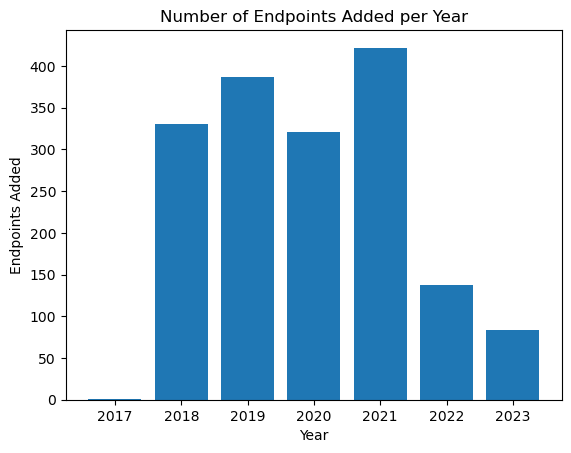

In [7]:
#endpoints added in each year 
params = urllib.parse.urlencode({
"sql": """
select substr(e.entry_date, 1, 4) as Year, count(e.endpoint) endpoints_added from endpoint e inner join source s on e.endpoint = s.endpoint group by Year order by Year
""",
"_size": "max"
})

url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url)
years = df['Year']
endpoints = df['endpoints_added']

#graph
plt.bar(years, endpoints)

plt.xlabel('Year')
plt.ylabel('Endpoints Added')
plt.title('Number of Endpoints Added per Year')

# Display data
display(df)
plt.show()


# Number of endpoints added per year per collection

In [8]:
#endpoints added in each year group by collection
params = urllib.parse.urlencode({
"sql": """
select substr(e.entry_date, 1, 4) as Year,s.collection, count(e.endpoint) endpoints_added from endpoint e inner join source s on e.endpoint = s.endpoint group by Year,s.collection Order by Year desc
""",
"_size": "max"
})

url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url)
df = df.pivot_table(index="collection", columns="Year", values="endpoints_added",  fill_value=0)
print("The values represents count of endpoints added for collection in that particular year")
df

The values represents count of endpoints added for collection in that particular year


Year,2017,2018,2019,2020,2021,2022,2023
collection,,,,,,,
ancient-woodland,0,0,0,0,2,0,0
area-of-outstanding-natural-beauty,0,0,0,0,1,1,0
article-4-direction,0,0,0,0,3,19,2
article-4-direction-area,0,0,0,0,0,5,0
brownfield-land,1,331,387,182,144,21,82
brownfield-site,0,0,0,3,0,0,0
central-activities-zone,0,0,0,0,2,0,0
central-activity-zone,0,0,0,0,1,0,0
conservation-area,0,0,0,58,6,8,0


# List of Endpoints erroring, Grouped by Collection Name

In [9]:
#endpoint list with collection name which has an error status 

params = urllib.parse.urlencode({
"sql": f"""
select
  l.endpoint,
  l.status,
  l.exception,
  s.collection,
  s.organisation,
  l.entry_date
from
  log l
  inner join source s on l.endpoint = s.endpoint 
 {date_query} and
  l.status != 200 
  and (
    l.end_date is null
    or l.end_date = ""
  ) 
 
group by
  l.endpoint,
  l.status
order by
  l.endpoint,s.collection,s.organisation, l.entry_date desc""",
"_size": "max"
})

url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url)
df

,endpoint,status,exception,collection,organisation,entry_date
0,02555422754afe68c07c2813ecc77960d7c31fabe28d9b...,NaN,SSLError,developer-contributions,local-authority-eng:HYN,2023-07-13T00:24:13Z
1,029cb9e14e0428ef9dc4a2d7afe8a8a904f19af1ad4cfc...,404.0,NaN,brownfield-land,local-authority-eng:CHL,2023-07-13T00:22:11Z
2,035221aa7f7ff460fd08b3612e5c05b48d1fea1e2453d1...,404.0,NaN,brownfield-land,national-park-authority:Q27159704,2023-07-13T00:22:11Z
3,035538e79df78d7564f052a0aa3c3fe2d4b12044fc49f9...,404.0,NaN,brownfield-land,national-park-authority:Q72617158,2023-07-13T00:22:11Z
4,03671eb3a3bf3a6d932458c62133d702802720baf3f355...,NaN,SSLError,developer-contributions,local-authority-eng:NTY,2023-07-13T00:24:13Z
...,...,...,...,...,...,...
469,ff2702756c14c9f349738b11b77ab0633a765e85c7ea82...,404.0,NaN,brownfield-land,local-authority-eng:DEB,2023-07-13T00:22:11Z
470,ff3a568c9cc2f76a4358e0a60a71a7c92c10f07df7e257...,404.0,NaN,conservation-area,local-authority-eng:NET,2023-07-13T00:05:00Z
471,ff6b5edced535bb121b7c9264383fdb42f9d52c847b64e...,404.0,NaN,brownfield-land,local-authority-eng:NUN,2023-07-13T00:22:11Z
472,ff932883d9f76806ea5f71cab465cce00119899aa3ec57...,404.0,NaN,brownfield-land,local-authority-eng:DAR,2023-07-13T00:22:11Z


In [10]:
download = input("Do you want to download the result? (yes/no): ")

if download.lower() == "yes":
    # Save the DataFrame as a CSV file
    df.to_csv("error_result.csv", index=False)
    print("Query result downloaded as 'error_result.csv'")

Do you want to download the result? (yes/no): no


# Weekly Error Rate Percentage Graph

In [11]:

start_date = "2023-01-01"
sql = F"""
select
  strftime('%Y',entry_date) as year,
  strftime('%W',entry_date)+1 as week,
  status,
  count(*) as count
from log
where entry_date >= '{start_date}'
 group by year, week, status
"""

params = urllib.parse.urlencode({
"sql": sql,
"_size": "max"
})

url = f"{datasette_url}digital-land.csv?{params}"
df = pd.read_csv(url, dtype={'status': str})

In [12]:
df["result"] = df["status"].apply(lambda status: "OK" if status == "200" else "Error")

In [13]:
df = df.pivot_table(index=["year", "week"], columns="result", values="count", aggfunc=np.sum, fill_value=0)

In [14]:
df["total"] = df["Error"] + df["OK"]
df["ratio"] = 100 * df["Error"] / df["total"]

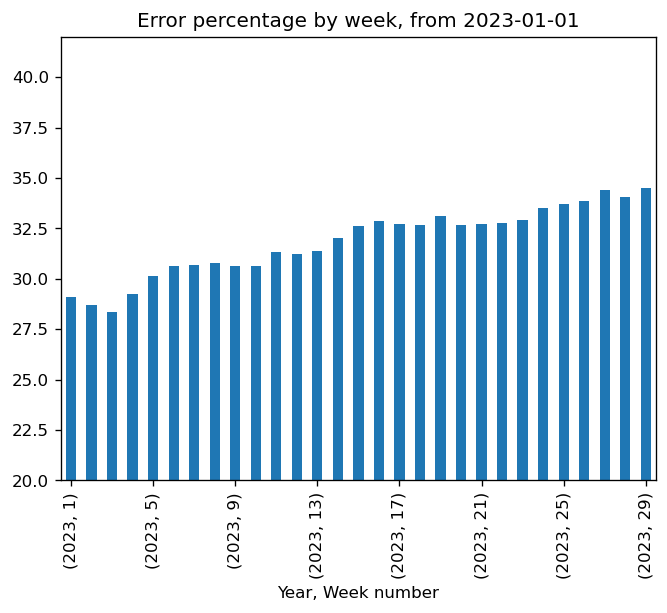

In [15]:
ymin = 4 * int((min(df["ratio"])) / 5) 
ymax = 6 * (math.ceil(max(df["ratio"])) / 5) 

plt.rcParams['figure.dpi'] = 120

ax = df.plot.bar(y="ratio" )

ax.set_title(F"Error percentage by week, from {start_date}")


ax.get_legend().remove()
ax.set_ylabel(None)
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Year, Week number")
xlocator = ticker.MaxNLocator (9) #(min(6,int(df.shape[0]/8)))
ax.xaxis.set_major_locator(xlocator)